In [0]:
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import count, when, array, array_compact, col
import matplotlib.pyplot as plt
import pandas as pd


spark = SparkSession.builder.appName("MarketBasketAnalysis").getOrCreate()
df = spark.read.csv('/FileStore/tables/Bakery_Sales.csv', header=True, inferSchema=True)
df.show(3)
print(df.count())

# Usuwanie zbędnych kolumn, kolumn i wierszy zawierających wyłącznie wartości null
df = df.drop('datetime','day of week','total','place', 'croque monsieur', 'mad garlic')
df = df.dropna(how='all')

# Tworzenie kolumny 'items' z listą zakupionych produktów
product_columns = df.columns[:]
df = df.withColumn(
    'items',
    array([when ((col(name) > 0), name) for name in product_columns])
)

items_df = df.select('items')
items_df.show(truncate=False)

# Usuwanie wartości nullowych w kolumnie 'items'
items_df = items_df.withColumn('items',array_compact('items'))
items_df.show(truncate=False)

print(items_df.count())



+-------------------+-----------+-----+-----+---------+-----------+----+---------+---------+-----------+------------------+----------+----------------+----------------+---------------+----------+--------+---------------+-------+-----------+---------+------------+------+------------+---------+--------+----------------+
|           datetime|day of week|total|place|angbutter|plain bread| jam|americano|croissant|caffe latte|tiramisu croissant|cacao deep|pain au chocolat|almond croissant|croque monsieur|mad garlic|milk tea|gateau chocolat|pandoro|cheese cake|lemon ade|orange pound|wiener|vanila latte|berry ade|tiramisu|merinque cookies|
+-------------------+-----------+-----+-----+---------+-----------+----+---------+---------+-----------+------------------+----------+----------------+----------------+---------------+----------+--------+---------------+-------+-----------+---------+------------+------+------------+---------+--------+----------------+
|2019-07-11 15:35:00|       Thur|23800| 

In [0]:

# Zastosowanie algorytmu FPGrowth
fpGrowth = FPGrowth(itemsCol="items", minSupport=0.05, minConfidence=0.3) 
model = fpGrowth.fit(items_df) 

# Frequent Itemsets
frequent_itemsets = model.freqItemsets   
frequent_itemsets.show(truncate=False)

# Association Rules
association_rules = model.associationRules
association_rules.show(truncate=False)
association_rules.orderBy(col("lift").desc()).show(truncate=False)

print("Liczba frequent itemsets:", frequent_itemsets.count())
print("Liczba reguł asocjacyjnych:", association_rules.count())

+--------------------------------------------+----+
|items                                       |freq|
+--------------------------------------------+----+
|[pandoro]                                   |343 |
|[pandoro, angbutter]                        |264 |
|[vanila latte]                              |209 |
|[vanila latte, angbutter]                   |153 |
|[tiramisu croissant]                        |779 |
|[tiramisu croissant, plain bread]           |246 |
|[tiramisu croissant, plain bread, angbutter]|173 |
|[tiramisu croissant, angbutter]             |601 |
|[orange pound]                              |519 |
|[orange pound, tiramisu croissant]          |162 |
|[orange pound, plain bread]                 |180 |
|[orange pound, plain bread, angbutter]      |122 |
|[orange pound, croissant]                   |141 |
|[orange pound, angbutter]                   |406 |
|[caffe latte]                               |193 |
|[caffe latte, angbutter]                    |139 |
|[gateau cho

                                              items  freq
48                                        angbutter  1973
33                                      plain bread   857
4                                tiramisu croissant   779
37                                        croissant   747
34                           plain bread, angbutter   648
7                     tiramisu croissant, angbutter   601
18                                 pain au chocolat   587
42                             croissant, angbutter   558
8                                      orange pound   519
25                      pain au chocolat, angbutter   440
45                                        americano   412
13                          orange pound, angbutter   406
26                                           wiener   355
0                                           pandoro   343
46                             americano, angbutter   326
35                                       cacao deep   323
40            

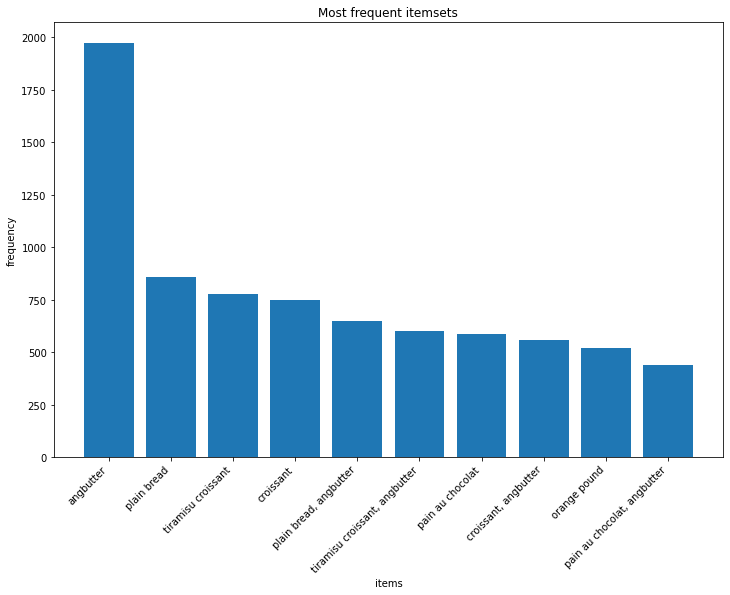

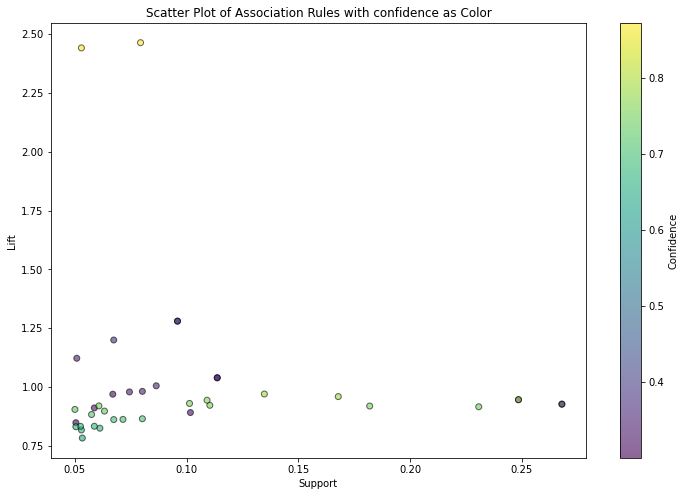

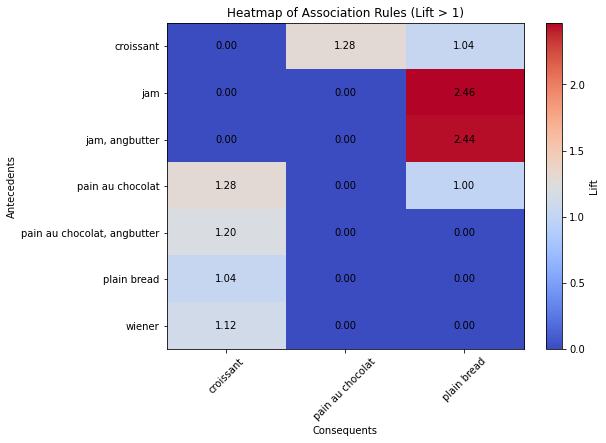

In [0]:
# Wizualizacja frequent itemsets i assosiation rules

# Wykres słupkowy dla frequent itemsets

frequent_itemsets_pd = frequent_itemsets.toPandas()
frequent_itemsets_pd = frequent_itemsets_pd.sort_values(by='freq', ascending = False)
frequent_itemsets_pd['items'] = frequent_itemsets_pd['items'].apply(lambda x: ', '.join(x))
print(frequent_itemsets_pd)

top10_items = frequent_itemsets_pd['items'].tolist()[:10]
top10_freq = frequent_itemsets_pd['freq'].tolist()[:10]

plt.figure(figsize=(12, 8)) 
plt.bar(top10_items, top10_freq)

plt.title('Most frequent itemsets')
plt.xlabel('items')
plt.ylabel('frequency')
plt.xticks(rotation=45, ha='right')


# Wykres punktowy - reguły asocjacyjne

association_rules_pd = association_rules.toPandas()
print(association_rules_pd)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    x=association_rules_pd['support'],
    y=association_rules_pd['lift'],
    c=association_rules_pd['confidence'],  # confidence jako kolor
    cmap='viridis',
    alpha=0.6,
    edgecolors="k"
)

# Dodanie paska kolorów i etykiet wierszy i kolumn
cbar = plt.colorbar(scatter)
cbar.set_label('Confidence')

plt.title('Scatter Plot of Association Rules with confidence as Color')
plt.xlabel('Support')
plt.ylabel('Lift')


# Wykres heatmap - reguły asocjacyjne z lift>1

association_rules_sorted = association_rules_pd[association_rules_pd['lift'] > 1].copy()
association_rules_sorted['antecedent'] = association_rules_sorted['antecedent'].apply(lambda x: ', '.join(x))
association_rules_sorted['consequent'] = association_rules_sorted['consequent'].apply(lambda x: ', '.join(x))

heatmap_data = association_rules_sorted.pivot_table(
    index='antecedent', columns='consequent', values='lift', fill_value=0
)

data_matrix = heatmap_data.values
row_labels = heatmap_data.index.tolist()
col_labels = heatmap_data.columns.tolist()

plt.figure(figsize=(8, 6))
plt.imshow(data_matrix, cmap='coolwarm', aspect='auto')

# Dodanie paska kolorów
cbar = plt.colorbar()
cbar.set_label('Lift')

plt.xticks(ticks=range(len(col_labels)), labels=col_labels, rotation=45)
plt.yticks(ticks=range(len(row_labels)), labels=row_labels)

# Dodanie wartości na macierzy
for i in range(data_matrix.shape[0]):
    for j in range(data_matrix.shape[1]):
        plt.text(j, i, f'{data_matrix[i, j]:.2f}', ha='center', va='center', color='black')

# Tytuł i etykiety osi
plt.title('Heatmap of Association Rules (Lift > 1)')
plt.xlabel('Consequents')
plt.ylabel('Antecedents')
plt.show()



In [0]:
# Znaczenie biznesowe znalezionych wzorców:
# Dwie najsilniejsze reguły asocjcyjne: jam -> plain bread (confidence = 0,87, lift = 2,46) oraz jam, angbutter -> plain bread 
# (confidence = 0,86, lift = 2,44). Można rozważyć stworzenie zestawów promocyjnych/śniadaniowych zawierających te pozycje.
# Między pozycjami pain au chocolat, croissant istnieje pozytywna zależność (lift na poziomie 1.28) --> Stworzenie zestawów promocyjnych, umieszczenie produktów obok siebie w fizycznym sklepie, reklama croissantów jako część "klasycznego francuskiego śniadania" razem z innymi wypiekami.

In [0]:
# dodatkowo - liczba reguł asocjacyjncyh i frequent itemsets w zależności od róznego poziomu minSupport i minConfidence

def test_fp_growth(items_df, min_supports, min_confidences):
    results = []
    for min_support in min_supports:
        for min_confidence in min_confidences:
            fpGrowth = FPGrowth(itemsCol="items", minSupport=min_support, minConfidence=min_confidence)
            model = fpGrowth.fit(items_df)
            
            # Zliczanie liczby frequent itemsets i reguł asocjacyjnych
            frequent_itemsets_count = model.freqItemsets.count()
            association_rules_count = model.associationRules.count()
            
            # Zapis wyników
            results.append({
                'minSupport': min_support,
                'minConfidence': min_confidence,
                'frequentItemsets': frequent_itemsets_count,
                'associationRules': association_rules_count
            })
    
    return results

# Wartości minSupport i minConfidence do przetestowania
min_supports = [0.01, 0.03, 0.05, 0.1]
min_confidences = [0.2, 0.3, 0.5, 0.7]

results = test_fp_growth(items_df, min_supports, min_confidences)
results_df = pd.DataFrame(results)
print(results_df)

    minSupport  minConfidence  frequentItemsets  associationRules
0         0.01            0.2               220               310
1         0.01            0.3               220               168
2         0.01            0.5               220               104
3         0.01            0.7               220                57
4         0.03            0.2                81               103
5         0.03            0.3                81                61
6         0.03            0.5                81                36
7         0.03            0.7                81                26
8         0.05            0.2                49                61
9         0.05            0.3                49                39
10        0.05            0.5                49                24
11        0.05            0.7                49                18
12        0.10            0.2                21                18
13        0.10            0.3                21                14
14        